# Genetic Algorithm for CVRP

### 從 VRP 到 CVRP 的程式調整
- 每個 Node 新增包裹重量
- 每台車新增重量限制
- 新增懲罰項, 當重量超過限制時, 懲罰值為超過的重量乘上懲罰係數 (L1 & L2 Regularization, Elastic nets)
- 調整目標函數方法, 目標函數 = 總路徑長度 + 懲罰項
- VRP 可理解成一台車回原點多次的 TSP 問題 (0 -> 4 -> 16 -> 3 -> 0 -> 7 -> 8 -> ... -> 0) 
- Selection 階段改用目標函數值來篩選
- 調整 Output 格式

(2023/09/14) 容量限制式的程式尚未完成

### Import 套件, 參數設定, 建立 Model

In [88]:
import random as rd
import numpy as np
import pandas as pd
import time
import copy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


NUM_NODES = 20
MAX_X = 100
MAX_Y = 100
NUM_VEHICLES = 4
NUM_DEPOT = 0
MAX_CAPACITY = 25

POPULATION_SIZE = 4
CROSSOVER_RATE = 0.5
MUTATION_RATE = 0.5
MAX_ITERATION = 100

PENALITY_COEF = 2000


def create_data_model():
    data = {}
    data['num_locations'] = [(rd.randint(1, MAX_X), rd.randint(1, MAX_Y)) for i in range(NUM_NODES)]
    data["num_locations"][0] = (int(MAX_X / 2), int(MAX_Y / 2))
    data["distance_matrix"] = compute_manhattan_distance_matrix(data['num_locations'])
    data["demands"] = [int(rd.uniform(1,10)) for i in range(NUM_NODES-1)] # 每個地點的一個需求，本案例為容量(Capacity)。第 0 Depot 的需求為 0
    data["demands"].insert(0, 0)
    data["num_vehicles"] = NUM_VEHICLES
    data["vehicle_capacities"] = [MAX_CAPACITY for i in range(NUM_VEHICLES)]
    data["depot"] = NUM_DEPOT
    return data

def compute_manhattan_distance_matrix(nodes):
    distance_matrix = []
    for node_i in nodes:
        distances = []
        for node_j in nodes:
            if node_i == node_j:
                distances.append(0)
            else:
                manhattan_distance = np.sum(np.abs(np.array(node_i) - np.array(node_j)))
                distances.append(manhattan_distance)
        distance_matrix.append(distances)
    return distance_matrix

# 記錄每次實驗參數與結果，一次實驗會包含多個迭代
def create_result_model():
    result = {}
    result['num_nodes'] = NUM_NODES
    result['num_vehicle'] = NUM_VEHICLES
    result['num_depot'] = NUM_DEPOT
    result['crossover_rate'] = CROSSOVER_RATE
    result['mutation_rate'] = MUTATION_RATE
    result['max_iteration'] = MAX_ITERATION
    result['used_capacity'] = np.nan
    result['objective'] = np.nan
    result['duration'] = np.nan
    result['unpassed_nodes'] = []

    return result

data = create_data_model()
result = create_result_model()

print("data['num_locations']:", data['num_locations'])
print("data['distance_matrix']:", data['distance_matrix'])
print("data['demands']:", data["demands"])

data['num_locations']: [(50, 50), (4, 20), (16, 35), (66, 22), (92, 68), (43, 22), (87, 89), (25, 57), (42, 79), (45, 38), (69, 53), (80, 91), (5, 42), (77, 40), (45, 1), (36, 44), (65, 43), (58, 92), (100, 4), (17, 4)]
data['distance_matrix']: [[0, 76, 49, 44, 60, 35, 76, 32, 37, 17, 22, 71, 53, 37, 54, 20, 22, 50, 96, 79], [76, 0, 27, 64, 136, 41, 152, 58, 97, 59, 98, 147, 23, 93, 60, 56, 84, 126, 112, 29], [49, 27, 0, 63, 109, 40, 125, 31, 70, 32, 71, 120, 18, 66, 63, 29, 57, 99, 115, 32], [44, 64, 63, 0, 72, 23, 88, 76, 81, 37, 34, 83, 81, 29, 42, 52, 22, 78, 52, 67], [60, 136, 109, 72, 0, 95, 26, 78, 61, 77, 38, 35, 113, 43, 114, 80, 52, 58, 72, 139], [35, 41, 40, 23, 95, 0, 111, 53, 58, 18, 57, 106, 58, 52, 23, 29, 43, 85, 75, 44], [76, 152, 125, 88, 26, 111, 0, 94, 55, 93, 54, 9, 129, 59, 130, 96, 68, 32, 98, 155], [32, 58, 31, 76, 78, 53, 94, 0, 39, 39, 48, 89, 35, 69, 76, 24, 54, 68, 128, 61], [37, 97, 70, 81, 61, 58, 55, 39, 0, 44, 53, 50, 74, 74, 81, 41, 59, 29, 133, 100], [

In [89]:
def plot_map(routes):
    plt.figure(figsize=(7, 7))
    plt.title('Vehicle Route Problem (VRP) solved by GA')
    plt.grid(color='gray', linestyle='-', linewidth=1, alpha=0.2)
    plt.xlim(0, MAX_X)
    plt.ylim(0, MAX_Y) 
    if len(routes) > 0:
        plotted_routes = copy.deepcopy(routes)
        for index, route in enumerate(plotted_routes):
            plotted_routes[index][0:0] = [0]
        
        for route in plotted_routes:
            # Draw lines
            RGB_colors = tuple(round(rd.uniform(0,1), 1) for i in range(3))
            arrow_kwargs = dict(length_includes_head=True, head_width=2.5, head_length=5, color=RGB_colors, alpha=0.8)

            for index, node in enumerate(route):
                start_loc = data['num_locations'][route[index]]
                end_loc = data['num_locations'][route[index + 1]] if index < (len(route) - 1) else data['num_locations'][0]

                plt.arrow(x=start_loc[0], y=start_loc[1], dx=(end_loc[0] - start_loc[0]), dy=(end_loc[1] - start_loc[1]), **arrow_kwargs)

            # Draw nodes
            for i in route:
                text_kwargs = dict(s=str(i), fontsize=10, color="white", horizontalalignment='center', verticalalignment='center')
                node_kwargs = dict(s=300, color='black', alpha=0.8, edgecolors='black')

                if i == 0: 
                    continue
                node_kwargs['color'] = RGB_colors
                node = data['num_locations'][i]
                plt.scatter(x=node[0], y=node[1], **node_kwargs)
                plt.text(x=node[0], y=node[1], **text_kwargs)

        # Draw start node
        start_node = data['num_locations'][0]
        plt.scatter(x=start_node[0], y=start_node[1], s=300, color='black', alpha=1, edgecolors='black') 
        plt.text(x=start_node[0], y=start_node[1], s='0', fontsize=10, color="white", horizontalalignment='center', verticalalignment='center')

        # Draw un-passed nodes
        if len(result['unpassed_nodes']) >= 1:
            for u_node in result['unpassed_nodes']:
                text_kwargs = dict(s=str(i), fontsize=10, color="white", horizontalalignment='center', verticalalignment='center')
                node_kwargs = dict(s=300, color='gray', alpha=0.8, edgecolors='black')
                node = data['num_locations'][u_node]
                plt.scatter(x=node[0], y=node[1], **node_kwargs)
                plt.text(x=node[0], y=node[1], **text_kwargs)
    else:
        # 尚未有解, 印出地圖與 Node 位置
        if len(data['num_locations']) > 0:
            for index, node in enumerate(data['num_locations']):
                text_kwargs = dict(s=str(index), fontsize=10, color="white", horizontalalignment='center', verticalalignment='center')
                node_kwargs = dict(s=300, color='gray', alpha=0.8, edgecolors='black')
                if index == 0: 
                    plt.scatter(x=node[0], y=node[1], s=300, color='black', alpha=0.8, edgecolors='black') 
                    plt.text(x=node[0], y=node[1], s='0', fontsize=10, color="white", horizontalalignment='center', verticalalignment='center')
                    continue
                plt.scatter(x=node[0], y=node[1], **node_kwargs)
                plt.text(x=node[0], y=node[1], **text_kwargs)
        else:
            print("No data to plot.")

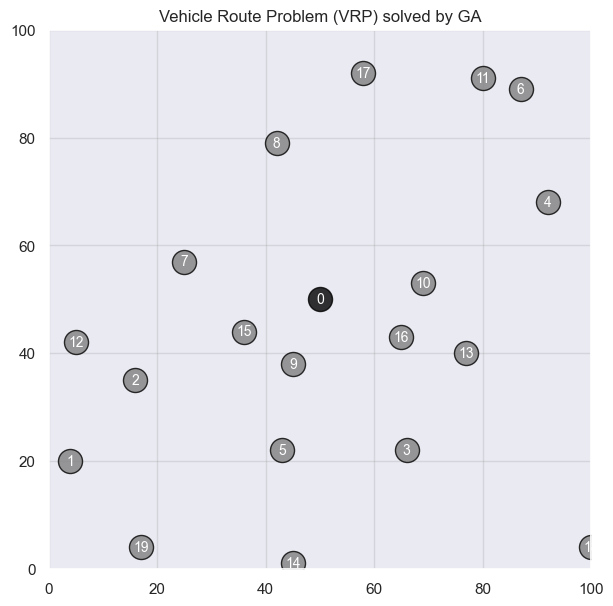

In [90]:
routes = []
plot_map(routes)

### Genetic Algorithm

In [91]:
# Getting Initial Solutoin of TSP by Greedy Algorithm
def solve_TSP_greedy_algorithm(start_index, nodes):

    optimal_route = [start_index]
    distances = copy.deepcopy(data['distance_matrix'])

    def do_iteration(node_index):
        if len(optimal_route) == (len(distances) - 1):
            optimal_route.append(0)
            return
        else:
            distances[node_index][0] = 999999
            distances[node_index][node_index] = 999999
            next_index = distances[node_index].index(min(distances[node_index]))
            optimal_route.append(next_index)
            for i in range(len(distances)):
                distances[i][node_index] = 999999
            return do_iteration(next_index)

    do_iteration(start_index)
    return optimal_route

# Calculating Objective Value
def get_total_distance(route):
    objective_value = 0
    total_distance = 0
    # print('Route:', route)
    total_distance += data['distance_matrix'][0][route[0]]
    for i in range(len(route)-1):
        total_distance += data['distance_matrix'][route[i]][route[i+1]]
    # print('Total Distance:', total_distance, '\n')
    return total_distance

# Printing Solution 
def print_solution(routes):
    for vehicle_id in range(0, len(routes)):
        index = 0
        plan_output = f"Route for vehicle {vehicle_id + 1}:\n0 -> "
        objective = get_total_distance(routes[vehicle_id])
        while index < len(routes[vehicle_id]) - 1:
            plan_output += f" {routes[vehicle_id][index]} -> "
            index += 1
        plan_output += f"0\nObjective Value: {objective} "
        
        print('\n', plan_output)

# Genetic Algorithm
def do_genetic_algorithm(routes):
    # Crossover
    def do_crossover(routes):
        num_crossover = 0
        for i in range(0, len(routes), 2):
            if i + 1 < len(routes):
                route1 = routes[i]
                route2 = routes[i + 1]
                if len(route1) == len(route2):
                    prob = rd.random()
                    if CROSSOVER_RATE > prob:
                        parent1, parent2 = route1.copy(), route2.copy()            
                        interval = rd.sample([i for i in range(0, len(parent1) - 2)], 2)
                        start, end = min(interval), max(interval)

                        genes1 = parent1[start:end]
                        offspring1 = [i for i in parent2 if i not in genes1]
                        index = rd.randint(0, len(offspring1) - 1)
                        offspring1[index:index] = genes1

                        genes2 = parent2[start:end]
                        offspring2 = [i for i in parent1 if i not in genes2]
                        offspring2[index:index] = genes2

                        routes += [offspring1, offspring2]
                        num_crossover += 1
                else:
                    print("Error: The length of two chromosome are not equal.")
        return routes
    # Mutation
    def do_mutation(routes):
        num_mutation = 0
        for i in range(len(routes)):
            route = routes[i] 
            chromosome = route.copy()
            prob = rd.random()
            if MUTATION_RATE > prob:
                num_mutation = rd.randint(1, len(chromosome)-1)
                mutation_indexes = rd.sample([i for i in range(0, len(chromosome)-1)], num_mutation)
                mutation_genes = [chromosome[i] for i in mutation_indexes]
                rd.shuffle(mutation_genes)
                for index, i in enumerate(mutation_indexes):
                    chromosome[i] = mutation_genes[index]
                    routes += [chromosome]
                    num_mutation += 1
        return routes
    # Selection
    def do_selection(chromosomes):
        chromosomes = list(set([tuple(chromosome) for chromosome in chromosomes]))
        chromosomes = [list(chromosome) for chromosome in chromosomes]

        if len(chromosomes) < POPULATION_SIZE:
            print(f'Chromosomes is less than {POPULATION_SIZE}. Regenerate chromosomes...')
            chromosomes += create_initial_solution()
            do_selection(chromosomes)
        chromosomes.sort(key=lambda x: get_total_distance(x))
        return chromosomes[:POPULATION_SIZE]
    
    population = do_mutation(do_crossover(routes))
    elites = do_selection(population)
    return elites

# All Processes
def main():

    start_time = time.time()
    
    initial_solution = []
    
    for i in range(POPULATION_SIZE):
        start_index = rd.randint(1, NUM_NODES - 1)
        TSP_greedy_solution = solve_TSP_greedy_algorithm(start_index, data['num_locations'])
        initial_solution.append(TSP_greedy_solution)
        # print(f"Initial Solution {i+1}: {TSP_greedy_solution}")

    iteration = 0

    optimal_solution = initial_solution.copy()

    while MAX_ITERATION >= iteration:
        iteration += 1
        optimal_solution = do_genetic_algorithm(optimal_solution)

    end_time = time.time()
    result['duration'] = round(end_time - start_time, 2)
    best_solution = optimal_solution[0]
    return [best_solution]

In [92]:
best_solution = main()

def get_total_demand(route):
    total_demand = 0
    for node in route:
        total_demand += data['demands'][node]
    return total_demand

print(best_solution)
print('Total Distance =', get_total_distance(best_solution[0]))
print('Total Demands =', get_total_demand(best_solution[0]))

[[16, 10, 13, 3, 5, 9, 15, 7, 2, 12, 1, 19, 14, 18, 4, 6, 11, 17, 8, 0]]
Total Distance = 552
Total Demands = 101


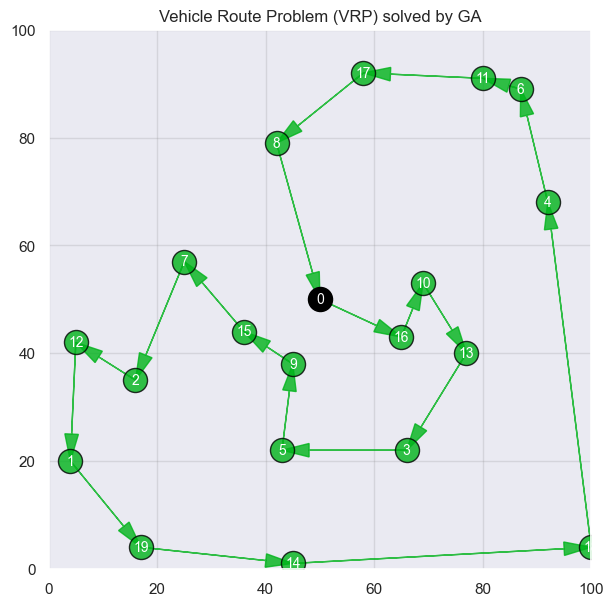

In [93]:
plot_map(best_solution)

In [96]:
def split_solution_by_vehicle(solution): 
    routes = []
    car_capacities = copy.deepcopy(data["vehicle_capacities"])
    car_index = 0
    start_index = 0 
    for index, node in enumerate(solution):
        print('Node', node, '貨物容量為:', data['demands'][node])
        # 車輛卸貨完畢, 返程並計算下一輛車重量
        if car_capacities[car_index] - data['demands'][node] < 0:
            print('車沒貨物了! 返回 Depot 換下一台', '\n')
            routes.append(solution[start_index:index])
            routes[car_index].append(0)
            start_index = index
            car_index += 1
            # 車輛數超出限制, 強制結束
            if car_index == NUM_VEHICLES:
                print('車輛已超出上限!!!')
                result['unpassed_nodes'] = solution[index:-1]
                print('未經過的點:', solution[index:-1])
                return routes
        car_capacities[car_index] -= data['demands'][node]
        print('已卸貨, 車輛', (car_index+1), '目前容量為:', car_capacities[car_index])
        # 最後一台車結束工作
        if node == solution[-1]:
            routes.append(solution[start_index:index])
            routes[car_index].append(0)
    result['used_capacity'] = car_capacities
    return routes

routes = split_solution_by_vehicle(best_solution[0])
print(routes)

Node 16 貨物容量為: 4
已卸貨, 車輛 1 目前容量為: 21
Node 10 貨物容量為: 5
已卸貨, 車輛 1 目前容量為: 16
Node 13 貨物容量為: 2
已卸貨, 車輛 1 目前容量為: 14
Node 3 貨物容量為: 3
已卸貨, 車輛 1 目前容量為: 11
Node 5 貨物容量為: 5
已卸貨, 車輛 1 目前容量為: 6
Node 9 貨物容量為: 2
已卸貨, 車輛 1 目前容量為: 4
Node 15 貨物容量為: 5
車沒貨物了! 返回 Depot 換下一台 

已卸貨, 車輛 2 目前容量為: 20
Node 7 貨物容量為: 9
已卸貨, 車輛 2 目前容量為: 11
Node 2 貨物容量為: 9
已卸貨, 車輛 2 目前容量為: 2
Node 12 貨物容量為: 3
車沒貨物了! 返回 Depot 換下一台 

已卸貨, 車輛 3 目前容量為: 22
Node 1 貨物容量為: 5
已卸貨, 車輛 3 目前容量為: 17
Node 19 貨物容量為: 6
已卸貨, 車輛 3 目前容量為: 11
Node 14 貨物容量為: 9
已卸貨, 車輛 3 目前容量為: 2
Node 18 貨物容量為: 4
車沒貨物了! 返回 Depot 換下一台 

已卸貨, 車輛 4 目前容量為: 21
Node 4 貨物容量為: 6
已卸貨, 車輛 4 目前容量為: 15
Node 6 貨物容量為: 6
已卸貨, 車輛 4 目前容量為: 9
Node 11 貨物容量為: 7
已卸貨, 車輛 4 目前容量為: 2
Node 17 貨物容量為: 6
車沒貨物了! 返回 Depot 換下一台 

車輛已超出上限!!!
未經過的點: [17, 8]
[[16, 10, 13, 3, 5, 9, 0], [15, 7, 2, 0], [12, 1, 19, 14, 0], [18, 4, 6, 11, 0]]


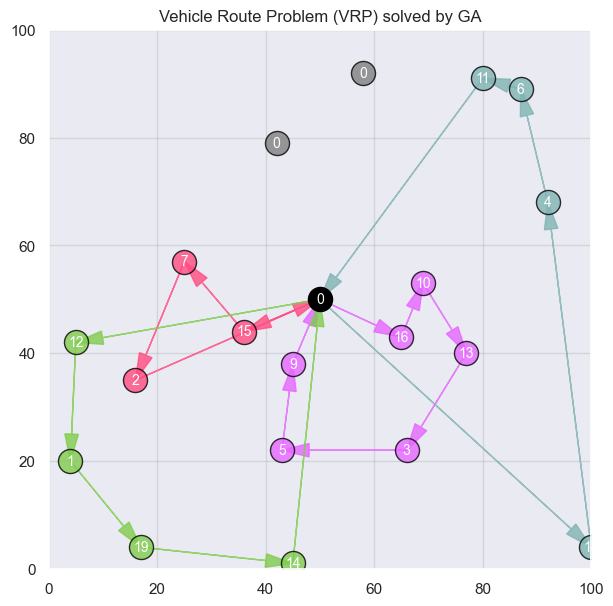

In [97]:
plot_map(routes)

In [103]:
# 考慮重量懲罰項的目標函數 = 總距離 + 懲罰係數
def get_objective_value(route):

    objective_value = 0
    total_distance = 0
    total_demand = 0

    total_distance += data['distance_matrix'][0][route[0]]
    for i in range(len(route)-1):
        total_distance += data['distance_matrix'][route[i]][route[i+1]]
        total_demand += data['demands'][route[i]]
    objective_value += total_distance
    # 重量超重的懲罰項
    if total_demand > MAX_CAPACITY:
        objective_value += PENALITY_COEF
    print('Objective:', objective_value, '\n')
    return objective_value

for index, route in enumerate(routes):
    print('Vehicle:', index+1, ':', route)
    get_objective_value(route)

Vehicle: 1 : [16, 10, 13, 3, 5, 9, 0]
Objective: 144 

Vehicle: 2 : [15, 7, 2, 0]
Objective: 124 

Vehicle: 3 : [12, 1, 19, 14, 0]
Objective: 190 

Vehicle: 4 : [18, 4, 6, 11, 0]
Objective: 274 

